### **FINAL PROJECT: A REPORT ON MINECRAFT PLAYERS AT UBC**

### **Introduction**

#### **Background**

This report is based on a research initiative led by Frank Wood at the University of British Columbia (UBC), which explores how individuals interact with video games, specifically Minecraft. The research group has developed a dedicated Minecraft server that tracks various aspects of player behaviour as they navigate an artificially generated world. The aim is to analyze this gameplay data to understand player characteristics better and improve recruitment strategies for future participants.

#### **Research Question:**
Can **hours played** and **age** predict **subscription** to a game newsletter in the players dataset?
This was influenced by Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Why this matters:**
Answering this question can help determine whether the age demographic of subscribers skews toward **youth or adults**. This insight can guide and improve outreach strategies to be better aligned with the target audience's behaviour and preferences.

#### **Data Description**

The analysis is based on a dataset named `player.csv`, which contains records of individual Minecraft players. Each row represents a unique player, and the dataset includes various attributes related to their identity and gameplay behaviour.

Key details about the dataset:

* **Number of observations**: 196
* **Number of variables**: 7
* **Data source**: Collected from a custom Minecraft server developed for research purposes

**Variable Summary:**

| Variable       | Type                  | Description                                                                   |
| -------------- | --------------------- | ----------------------------------------------------------------------------- |
| `Experience`   | Categorical (Ordinal) | Player experience level: veteran, professional, regular, amateur, or beginner |
| `Subscribe`    | Categorical (Binary)  | Whether the player subscribed to a game-related newsletter (Yes/No)           |
| `hashedEmail`  | Character             | Encrypted unique identifier for each player                                   |
| `played_hours` | Numeric               | Total hours the player has spent playing Minecraft                            |
| `Name`         | Character             | In-game username of the player                                                |
| `Gender`       | Categorical           | Player's gender                                                               |
| `Age`          | Numeric               | Player’s age in years                                                         |

**Potential Data Issues:**

* Some variables (e.g., `hashedEmail`, `Name`) are not analytically useful for prediction and will be excluded.
* There may be missing or inconsistent values in `played_hours` or `Age` that require cleaning.

In [1]:
# Load packages 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Set seed to account for reproducibility 
set.seed(1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# Read in the data file and display as a table
url <- "https://raw.githubusercontent.com/mwekesak/Files/refs/heads/main/players.csv"
players <- read_csv(url)
players 

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### **Methods & Results**

To perform this analysis, I used a **classification model** to predict whether a new player would subscribe to a game-related newsletter, based on the variables, **age** and **hours played**.

I began with **exploratory visualization**, creating a histogram of `subscribe` vs. `played_hours`, then another showing `subscribe` vs. `Age`. This helped identify patterns and potential relationships between the variables.

The dataset used for the exploratory data analysis is `players_final`, which includes only the relevant variables: `played_hours`, `Age`, and `subscribe`. Since the goal is to perform a **classification analysis** using `subscribe` as the response variable, I converted it from a **logical** type to a **factor** to ensure compatibility with modelling functions.

In [3]:
# Select the variables that are contributing to the analysis 
# Drop any N/A values to aid in simplicity 
players_clean <- players |> select(Age, played_hours, subscribe) |>
    drop_na()

# Convert the subscribe (logical) variable into a factor type 
players_final <- players_clean |> 
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

The range of `played_hours` was too large to visualize clearly when plotting against `subscribe`. To address this, I calculated the **mean** of `played_hours` and extracted the **20 data points closest to the mean**. This subset, stored in a new dataset called `closest_hours`, included the same variables as `players_final` (`Age`, `played_hours`, and `subscribe`), and an additional column, `distance`, which indicated how far each selected value was from the mean.

[1] 5.904639

Age,played_hours,subscribe,distance
<dbl>,<dbl>,<fct>,<dbl>
17,5.6,Yes,0.3046392
17,7.1,No,1.1953608
21,4.0,Yes,1.9046392
⋮,⋮,⋮,⋮
25,1.5,Yes,4.404639
20,1.5,Yes,4.404639
25,1.4,No,4.504639


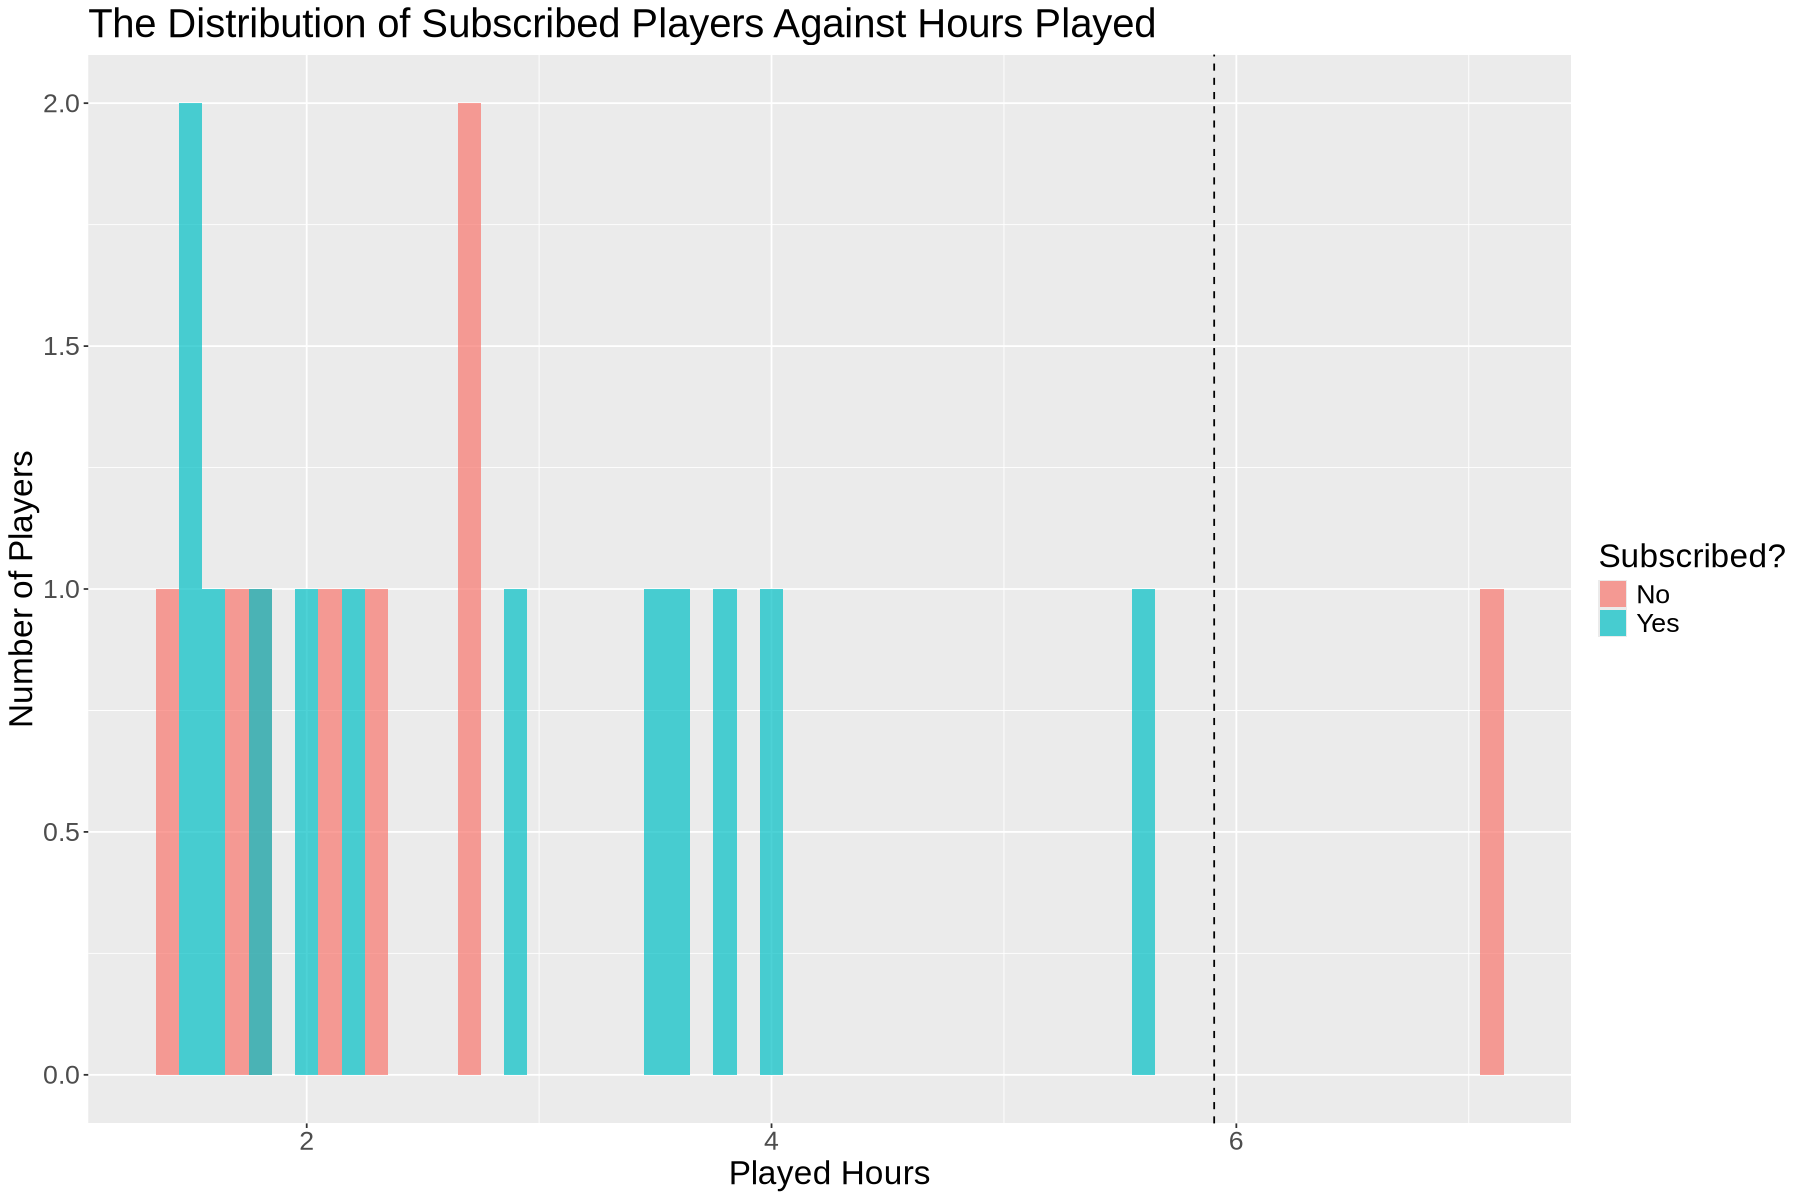

In [4]:
# Set dimensions for plot height and width 
options(repr.plot.height = 10, repr.plot.width = 15)

# Find the mean of the played hours in the table
mean_played_hours <- players_final |> summarize(avg = mean(played_hours, na.rm = TRUE)) |> pull()

mean_played_hours

# Gather the 20 closest points to the mean played hours 
closest_hours <- players_final |> 
  mutate(distance = abs(played_hours - mean_played_hours)) |> 
  arrange(distance) |> 
  slice_head(n = 20)

closest_hours

# Create a histogram for Played hours vs. Subscribed 
subscribed_vs_hours <- closest_hours |> ggplot(aes(x = played_hours, fill = subscribe)) + geom_histogram(alpha = 0.7 , position = "identity", binwidth = 0.1) + 
    geom_vline(xintercept = mean_played_hours, linetype = "dashed") + xlab("Played Hours") + ylab("Number of Players") + 
    theme(text = element_text(size = 20)) + labs(fill = "Subscribed?")  + 
    ggtitle("The Distribution of Subscribed Players Against Hours Played")

subscribed_vs_hours

Figure 1.0: The plot shows that when players have **fewer played hours**, there is an **equal likelihood of being subscribed or unsubscribed**. However, as **played hours increase**, players appear **less likely to be subscribed**. Interestingly, at **moderate or average levels of playtime**, subscription rates are **higher**. This pattern suggests a **nonlinear relationship** between played hours and subscription status, indicating that **played hours may be a useful predictor** of whether a player is subscribed.

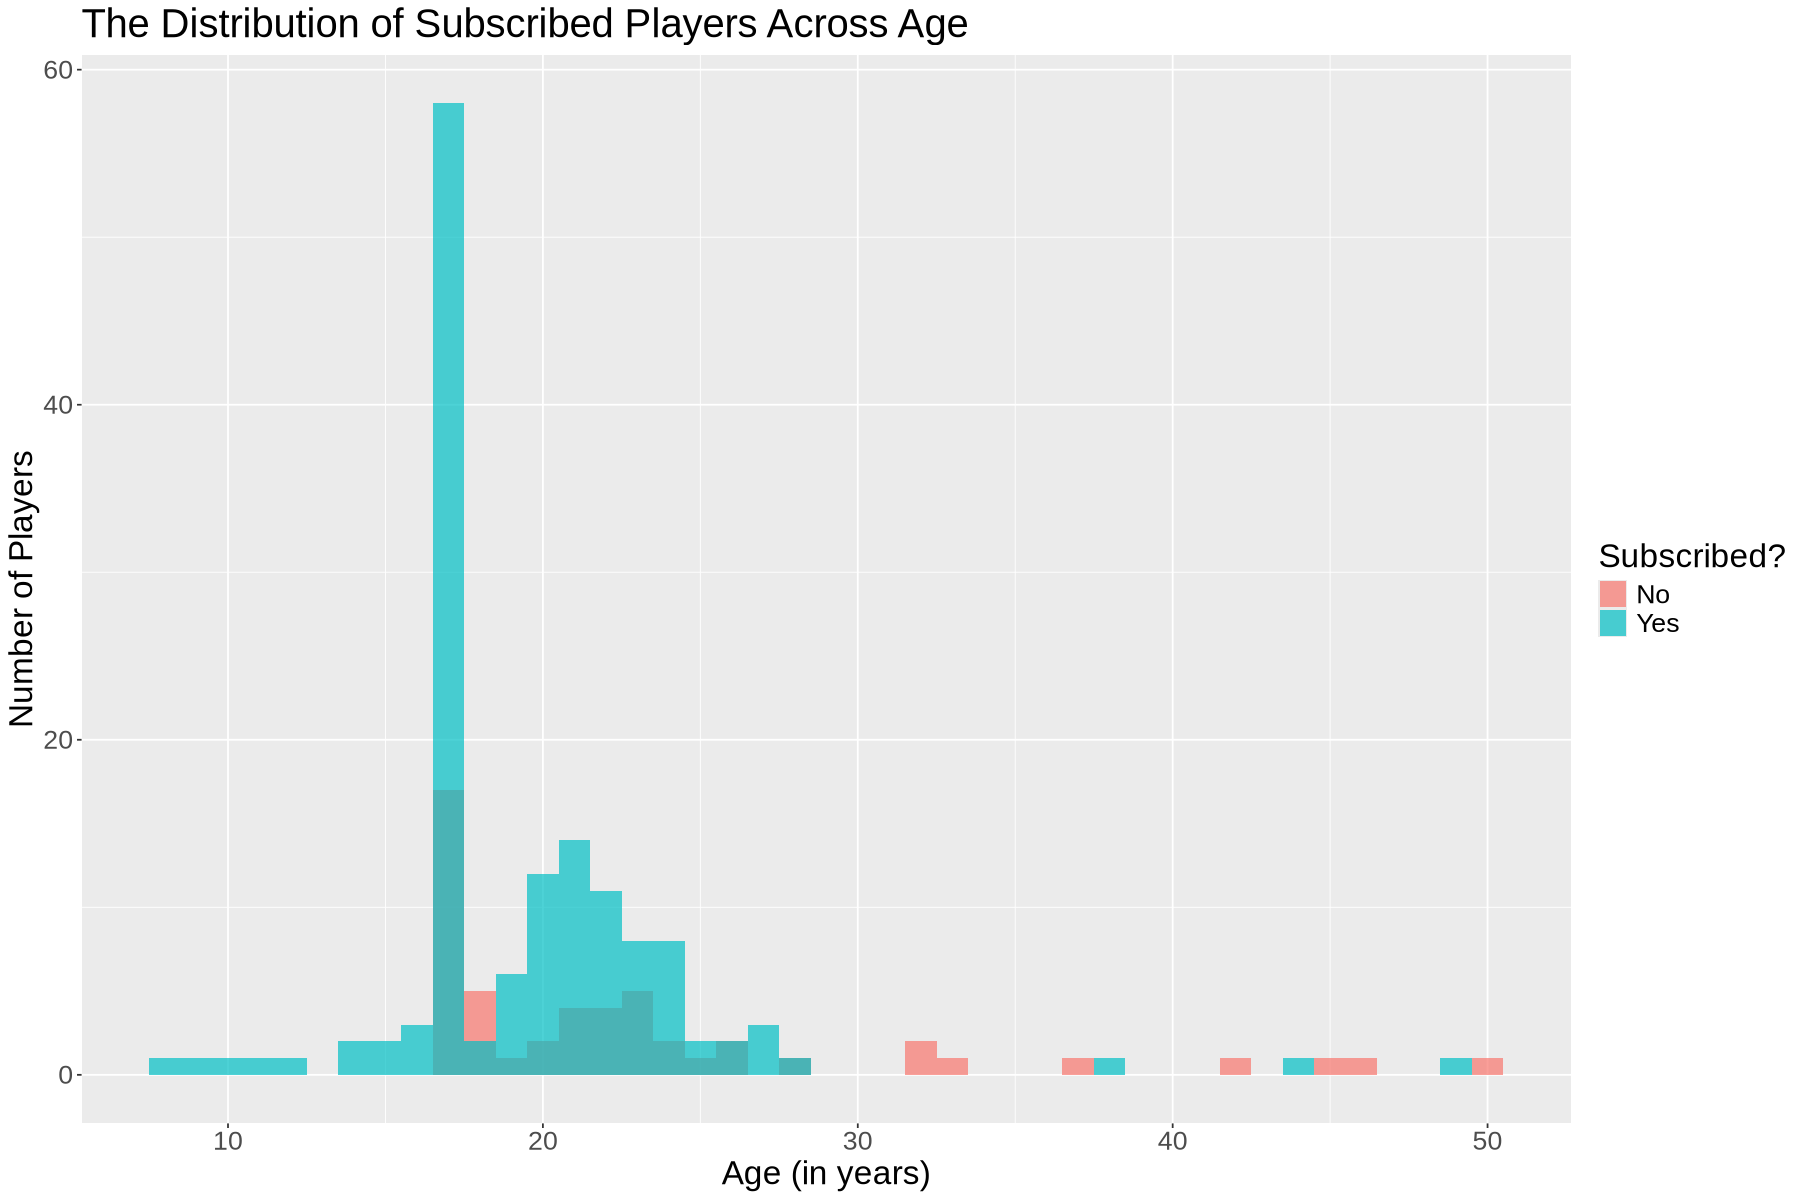

In [5]:
# Create a histogram for Age vs. Subscribed 
subscribed_vs_age <- players_final |> ggplot(aes(x = Age, fill = subscribe)) + geom_histogram(alpha = 0.7, position = "identity", binwidth = 1) + 
    xlab("Age (in years)") + ylab("Number of Players") + theme(text = element_text(size = 20)) + labs(fill = "Subscribed?") + 
    ggtitle("The Distribution of Subscribed Players Across Age")

subscribed_vs_age

Figure 2.0: The plot shows a trend where **younger players are more likely to subscribe** to the newsletter, while for **older players, the likelihood of subscribing becomes more balanced**—with roughly equal chances of being subscribed or not. This suggests a correlation between **age and subscription status**, and is a meaningful predictor for determining whether a new player is likely to subscribe.

Next, I created a scatter plot of `Age` versus `played_hours`, colored by subscription status.

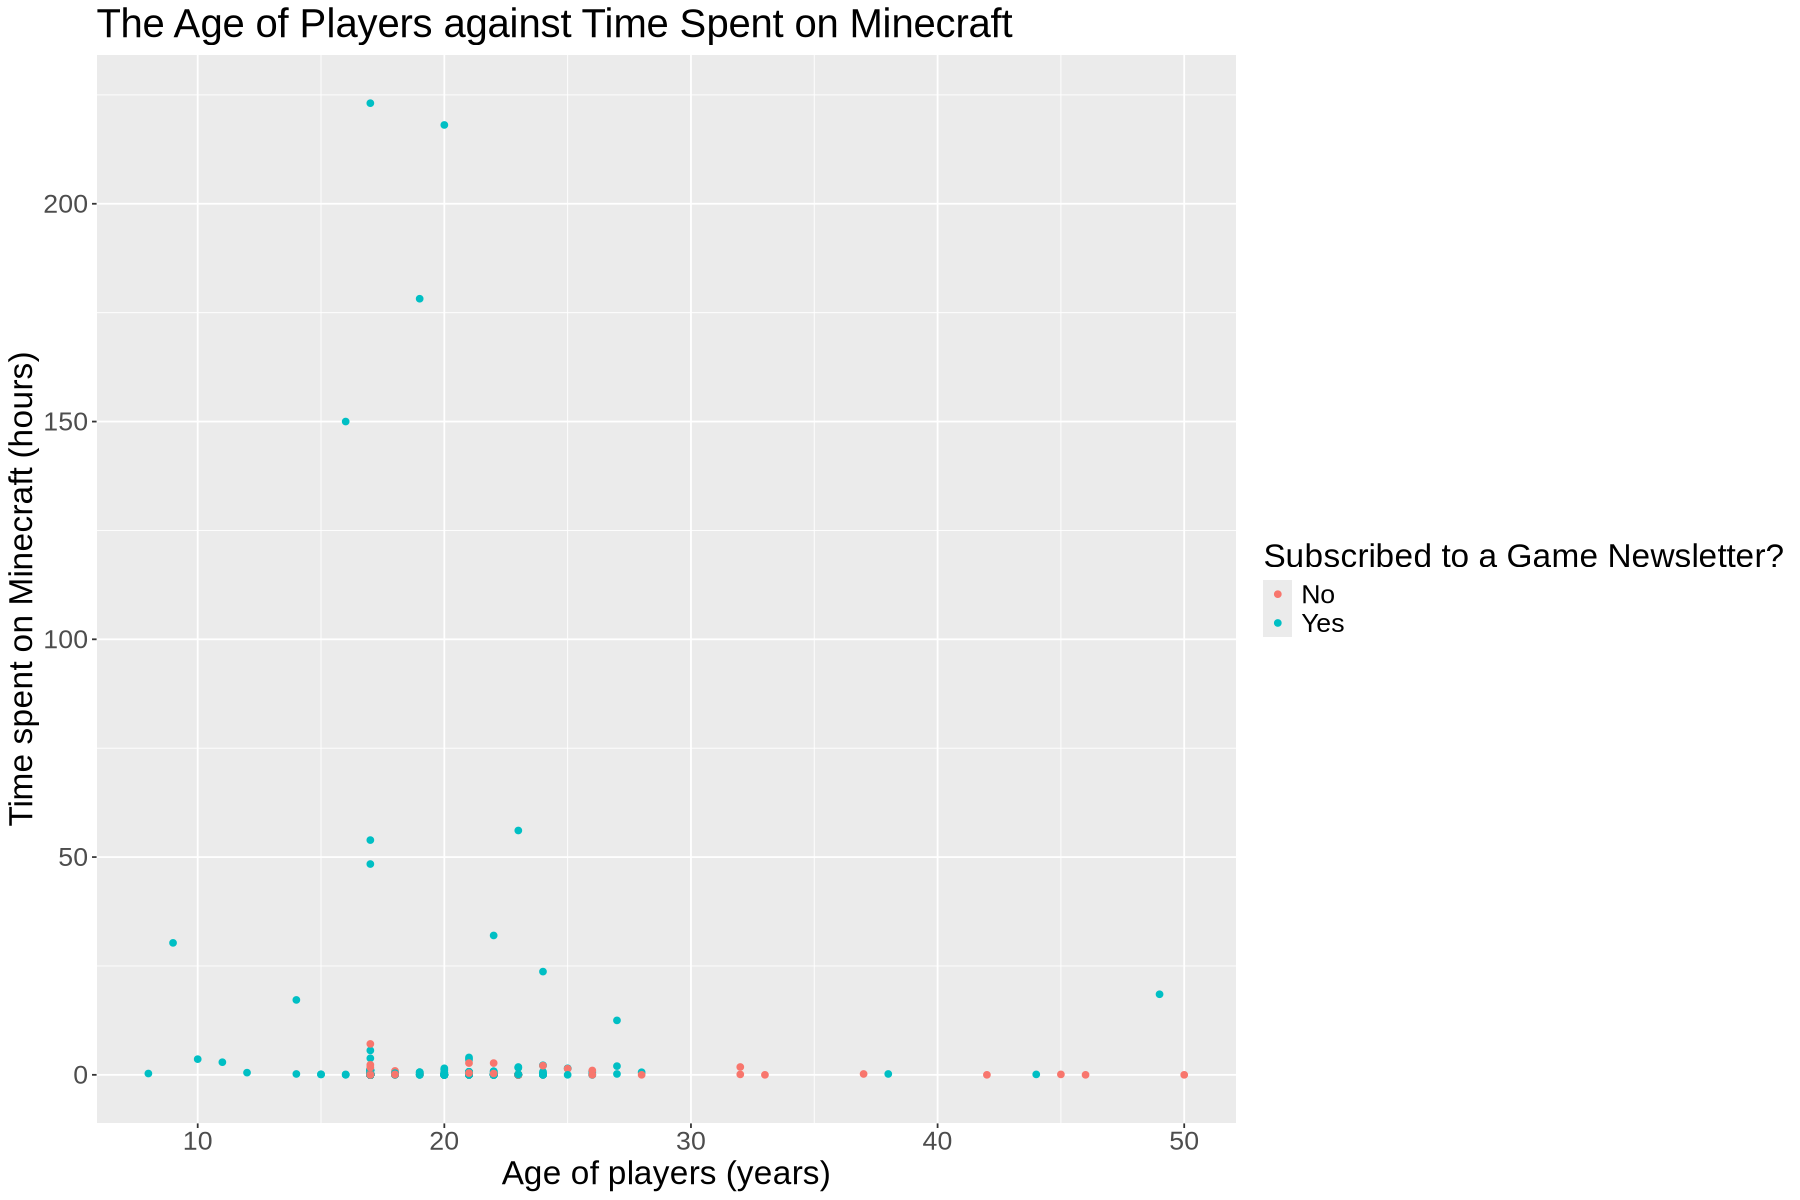

In [6]:
# Create a scatter plot of Age vs Hours played with Subscription 
players_plot <- players_final |> ggplot(aes(x = Age, y = played_hours, colour = subscribe)) + geom_point() +
    xlab("Age of players (years)") + ylab("Time spent on Minecraft (hours)") + labs(color = "Subscribed to a Game Newsletter?") + 
    theme(text = element_text(size = 20)) + ggtitle("The Age of Players against Time Spent on Minecraft")

players_plot

Figure 3.0: The data is not standardized—**`played_hours` has a much larger scale than `Age`**. To ensure that both variables contribute equally to the classification model, it is essential to **standardize the data**. 

Next, I implemented a **K-Nearest Neighbours (K-NN)** classifier. 

### **Why is this method appropriate?**

The response variable—whether a player is subscribed or not—is **categorical**, making **classification** an appropriate modelling approach. Specifically, **K-Nearest Neighbours (K-NN)** is a non-parametric, intuitive algorithm that is well-suited for small datasets with clear decision boundaries.

### **Which assumptions are required, if any, to apply the method selected?**

The **K-Nearest Neighbours (K-NN)** algorithm makes **no formal assumptions**, which is one of its main advantages. However, there are still important **practical considerations** to ensure reliable performance:

* **Feature scaling is essential**: Since K-NN uses distance-based calculations, all predictors should be **standardized or normalized** to prevent variables with larger scales from dominating the distance metric.
* **Meaningful distance metrics**: The input variables must be suitable for computing distances, typically numeric and continuous. Categorical variables may require encoding methods or different distance functions.

### **What are the potential limitations or weaknesses of this method?**

While K-NN is simple and easy to implement, it comes with several limitations:

* It becomes **computationally expensive** and slow as the size of the training data increases.
* It may perform poorly when the dataset includes **many irrelevant or high-dimensional predictors**, since all features contribute equally to the distance metric.
* It is sensitive to **imbalanced classes**, where one category dominates, which can skew predictions.
* It does not inherently provide a way to explain the decision process (i.e., it lacks interpretability compared to some other models).

### **How did you compare and select the model?**

I selected K-NN because the goal of the analysis was to **predict a binary outcome**, making classification a natural fit. After choosing K-NN, I used **cross-validation** to test different values of K and assess model performance based on **accuracy**, **precision**, and **recall**. This tuning process helped me select the best K-value for balancing prediction quality and model simplicity.

To begin, I split the data into **training and testing sets** and made a recipe to standardize the data. Then I built a model to fit the training dataset. 

In [7]:
# Create the training and testing sets
# 75% of the orginial data will be placed into the training set 
players_split <- initial_split(players_final, prop = 0.75, strata = subscribe) 

# Extract the training and testing data sets into two separate data frames 
players_train <- training(players_split) 
players_test <- testing(players_split) 

# Create a recipe and standardize the data 
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

# Train the classifier 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
    set_engine("kknn") |>
    set_mode("classification") 

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train) 

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4965517
Best kernel: rectangular
Best k: 3

Then, I evaluated the classifiers’ performance using **accuracy**, **precision**, **recall**, and the **confusion matrix**. I have chosen the subscribed variable ("Yes") to be the positive and the unsubscribed variable ("No") to be the negative, which is important for the confusion matrix. 

In [8]:
# Use the K-NN classifier to predict the class labels for the test set 
players_test_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test) 

players_test_predictions

.pred_class,Age,played_hours,subscribe
<fct>,<dbl>,<dbl>,<fct>
No,17,0.0,No
Yes,21,0.1,Yes
Yes,21,0.0,No
⋮,⋮,⋮,⋮
Yes,17,0.4,Yes
No,20,0.0,Yes
No,17,0.0,No


In [9]:
# Test the accuracy of the classifier 
players_test_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


In [10]:
#Confirm whether the positive label "Yes" is first or second in the subscribe variable 
players_test_predictions |> pull(subscribe) |> levels()

[1] "No"  "Yes"

In [11]:
# Obtain the precision 
players_test_predictions |> 
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8333333


In [12]:
# Obtain the recall
players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second") 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5555556


In [13]:
# Print the confusion matrix 
confusion <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction No Yes
       No   9  16
       Yes  4  20

The confusion matrix reveals that the model correctly identified 9 true negatives and 20 true positives. However, it also made 16 false negatives and 4 false positives. These results correspond to a precision of 83% and a recall of 56%, indicating that while the model is fairly precise when it predicts a subscription, it misses a significant number of actual subscribers. The initial model accuracy is 60%, which is relatively low. 

To address this, I improved the model by applying cross-validation and tuning the K-value to find the optimal number of neighbours for the classifier. Cross-validation can calculate an accuracy for each value of K in a reasonable range, and then pick the value of K that gives the best accuracy. 

In [14]:
# Select C = 5 because the more folds, the better the accuracy estimate will be (lower standard error) 
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe) 

players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit_resamples(resamples = players_vfold) 

knn_fit |> collect_metrics()

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.4608539,5,0.05020995,Preprocessor1_Model1
roc_auc,binary,0.4388026,5,0.06027877,Preprocessor1_Model1


In [15]:
# Tune the model parameter by specifying the tune() function 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification") 

# Create a data frame with a neighbours variable that contains the sequence of K values to try 
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) 

# Fit the model for each value in a range of parameter values 
knn_results <- workflow() |> 
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy") 

accuracies 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.3782923,5,0.05161911,Preprocessor1_Model01
6,accuracy,binary,0.4399179,5,0.06691903,Preprocessor1_Model02
11,accuracy,binary,0.7173235,5,0.01939741,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model18
91,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model19
96,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model20


Finally, find which number of neighbours is best by plotting the accuracy versus K. 

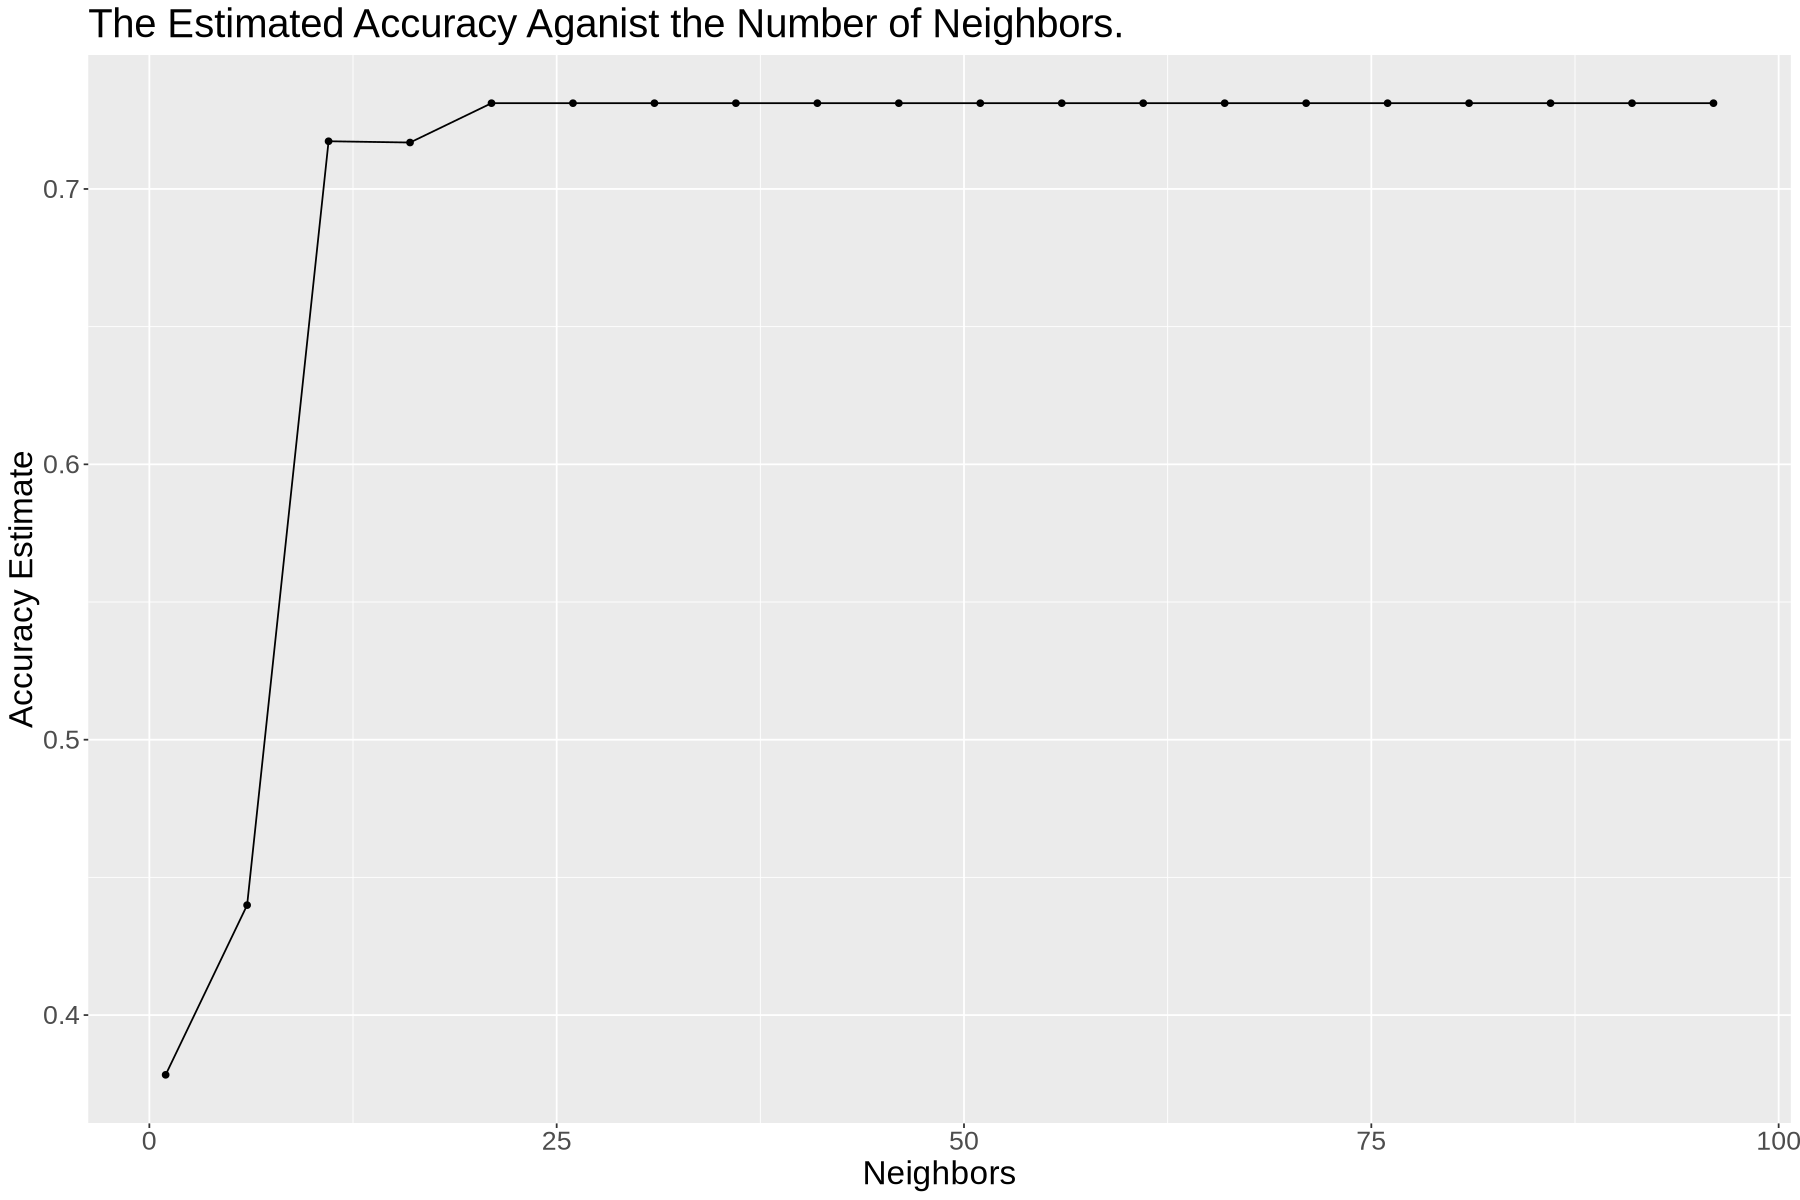

In [16]:
# Line plot of Accuracy vs K neighbours 
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) + geom_point() + 
    geom_line() + labs(x = "Neighbors", y = "Accuracy Estimate") + theme(text = element_text(size = 20))  + 
    ggtitle("The Estimated Accuracy Aganist the Number of Neighbors.")

accuracy_vs_k

Figure 4.0: Despite identifying the best K-value from the plot, the model shows signs of **underfitting**, meaning it fails to capture the underlying patterns in the data. As a result, it is not a strong predictive model. I have chosen **K = 10** as it represents a **reasonable balance between underfitting and overfitting**, offering more stability for the remainder of the analysis.

In [17]:
# Obtain the number of neighbours with the highest accuracy programmatically 
best_k <- accuracies |> arrange(desc(mean)) |> head(1) |> pull(neighbors)

best_k

[1] 21

Now, evaluate the quality of its predictions on the test data by retraining the K-NN classifier on the entire training dataset using the selected number of neighbours. 

In [18]:
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
    set_engine("kknn") |>
    set_mode("classification") 

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec)|>
    fit(data = players_train) 

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3034483
Best kernel: rectangular
Best k: 10

To make predictions and assess the estimated accuracy of the best model on the test data, use the predict and metrics functions. Pass those predictions to the precision, recall, and conf_mat functions.

In [19]:
# Check the accuracy of the training set and whether the cross-validation found a good K value that fits the model 
players_train_predictions <- predict(knn_fit, players_train) |>
    bind_cols(players_train) 

players_train_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6206897


In [20]:
players_test_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test) 

players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612


In [21]:
players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7567568


In [22]:
players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7777778


In [23]:
confusion <- players_test_predictions |> 
    conf_mat(truth = subscribe, estimate = .pred_class) 
confusion

          Truth
Prediction No Yes
       No   4   8
       Yes  9  28

### **Discussion**

#### **Summary of Findings**

The results of this project showed that the accuracy of the classification model was too low to reliably predict whether a new player would subscribe to a game-related newsletter. This suggests that the current predictors—such as age and hours played—may not provide enough meaningful information to make accurate predictions about subscription behaviour. 
After tuning the model, the **accuracy increased from 60% to 65%**, and the **recall improved significantly from 56% to 78%**. These are positive developments, indicating that the model is now better at identifying actual subscribers. However, the **precision decreased from 83% to 77%**, which suggests that the model is making more false positive predictions. While the improvements are encouraging, the results still indicate that the model is not yet reliable enough for strong predictive performance.
The **training model achieved an accuracy of 62%**, which is comparable to the **65% accuracy on the test set**. This similarity suggests that **cross-validation was effective** in selecting a suitable model parameter. In addition, the model **generalizes well to unseen data**, without significant overfitting or underfitting.

#### **Alignment with Expectations**

These results were somewhat unexpected. Based on the exploratory data analysis, there appeared to be correlations between the predictors and the response variable. I initially expected the model to perform with reasonably high accuracy. The low performance indicates that these observed correlations may not have been strong or consistent enough to support effective classification.

#### **Implications of Findings**

The key implication is that the current model is not sufficient for practical use. To build a more accurate classifier, additional or alternative predictors should be considered. This highlights the need for further data collection or feature engineering to identify variables that better explain subscription behaviour.

#### **Future Questions**

These findings lead to several follow-up questions:

* What other variables could better predict subscription behaviour?
* Would adjusting the K-value or tuning other model parameters improve performance?
* Is a different classification algorithm more appropriate for this task?
* Could combining behavioural and demographic features enhance the model?

### **References**

Pacific Laboratory for Artificial Intelligence. (2024, December 5). Home page - Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/ 